In [1]:
pip install tensorflow==2.17.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [7]:
#uncompress
!tar -xf lfw.tgz

In [8]:
 #movinf lfw images to negative image data
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
# Import uuid library to generate unique image names
import uuid

In [11]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data\\anchor\\69cec9d5-a527-11ef-8c49-a0595065cfce.jpg'


In [15]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [17]:
img = preprocess('data\\anchor\\69cec9d5-a527-11ef-8c49-a0595065cfce.jpg')

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
exampples=samples.next()

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*exampples)

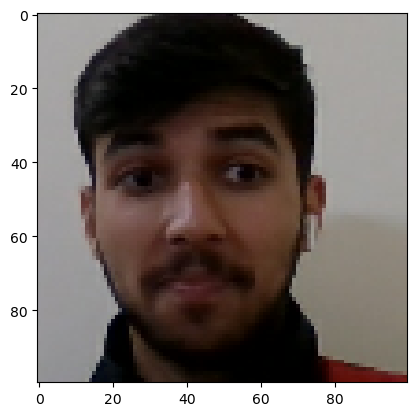

In [23]:
plt.imshow(res[0])

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [26]:
samples = data.as_numpy_iterator()

In [27]:
samp = samples.next()

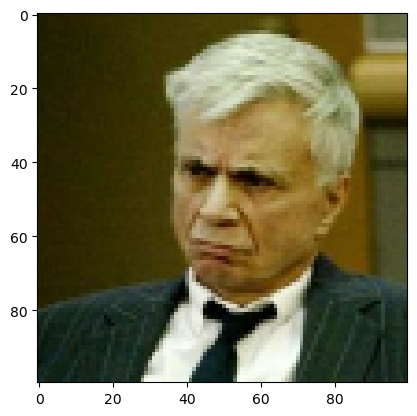

In [28]:
plt.imshow(samp[1])

In [29]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
train_samples = train_data.as_numpy_iterator()

In [31]:
train_sample=train_samples.next()

In [32]:
len(train_sample[0])

16

In [33]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [34]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        # Convert to tensors if they are lists
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)


In [38]:
l1 = L1Dist()

In [39]:
def make_siamese_model(): 
    # Anchor image input
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image input
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Embedding layers
    embedded_input = embedding(input_image)
    embedded_validation = embedding(validation_image)
    
    # Combine Siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedded_input, embedded_validation)
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    # Build the model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [40]:
siamese_model = make_siamese_model()

In [41]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [43]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [44]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [45]:
test_batch = train_data.as_numpy_iterator()

In [46]:
batch_1 = test_batch.next()

In [47]:
X=batch_1[:2]

In [48]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [49]:
Y = batch_1[2]

In [50]:
Y

array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [51]:
yhat = siamese_model(X, training=True)

In [52]:
Y.shape

(16,)

In [53]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        # Expand target dimensions to match yhat
        y = tf.expand_dims(y, axis=-1)  # (16,) -> (16, 1)
        y = tf.expand_dims(y, axis=0)  # (16, 1) -> (1, 16, 1)

        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [54]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [55]:
EPOCHS = 50

In [56]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step

 Epoch 15/50
27/27 ━

In [57]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [58]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [59]:
test_var = test_data.as_numpy_iterator().next()

In [60]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [61]:
y_hat

array([[[9.2649438e-12],
        [9.9999958e-01],
        [2.8290472e-07],
        [9.9997169e-01],
        [9.9997896e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0717472e-15],
        [1.2650278e-11],
        [3.6114838e-15],
        [6.0590639e-07],
        [1.0000000e+00],
        [9.9999738e-01],
        [4.0251190e-13],
        [9.9993920e-01],
        [1.1872048e-12]]], dtype=float32)

In [62]:
processed_predictions = [1 if prediction > 0.5 else 0 for prediction in y_hat.flatten()]

In [63]:
processed_predictions

[0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]

In [64]:
y_true

array([0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [65]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [66]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

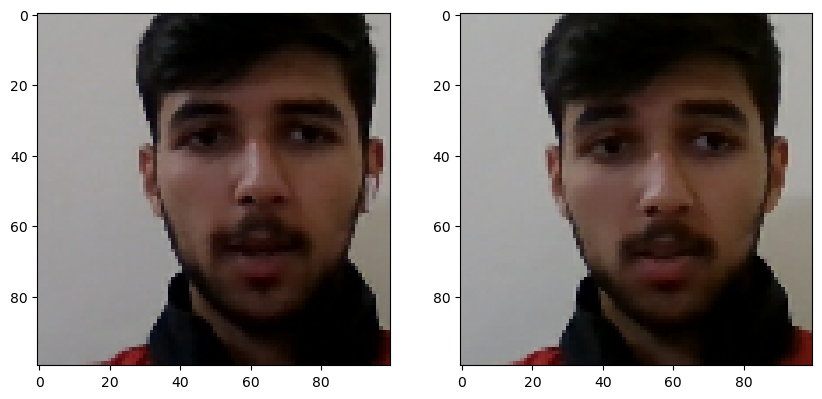

In [67]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# Renders cleanly
plt.show()

In [68]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [69]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [1]:
# Make predictions with reloaded model
y_pred = siamese_model.predict([test_input, test_val])

NameError: name 'siamese_model' is not defined

In [71]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [75]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━